# Road Object Detection using Fine-Tuned Pre-Trained Neural Networks 
**Advanced Intelligent Systems - Final Project**

*Group Members*
- Advincula, Andre Frederick
- Alvarez, Aaron Jetro
- Dee, Giann Wayne
- Gulinao, Lance Owen
- Laguna, Ivan Matthew
- Uy, Alec Matthew
- Verceles, Miguel Angelo




## Objectives

1. **Dataset Exploration and Understanding**  
   - Analyze the BDD100K dataset, focusing on object classes, distributions, and label properties, to assess its suitability for object detection tasks.

2. **Data Preprocessing and Preparation**  
   - Prepare images and annotations for YOLO by resizing, normalizing, and converting labels into YOLO-compatible formats to maximize model efficiency.

3. **Model Selection and Training**  
   - Fine-tune a YOLOv8 model (initially pre-trained on a generic dataset) for specific road object detection tasks, adjusting parameters like batch size, image size, and number of epochs to optimize performance on the BDD100K dataset.

4. **Evaluation and Analysis of Detection Performance**  
   - Evaluate the YOLO model’s object detection accuracy using metrics like mAP (mean Average Precision), precision, and recall, comparing pre- and post-fine-tuning results.

5. **Insights on YOLOv8 Fine-Tuning**  
   - Document findings on how fine-tuning parameters influence YOLO's ability to detect road objects, identifying challenges and potential improvements for future work.

6. **Comparison with Benchmark Models (if applicable)**  
   - Optionally, compare YOLO’s detection performance with other state-of-the-art models to contextualize results and highlight YOLO’s strengths and limitations.


# 1) Importing Libraries and data set

### Installing and Importing libraries for the modelling process

In [2]:
#Importing necessary libraries

from ultralytics import YOLO
import matplotlib.pyplot as plt
import kagglehub
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
import cv2
import os
import json
import tensorflow as tf
import exploratorymethods as em
import bddtools as bt
import metrictools as mt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib


importlib.reload(bt)
importlib.reload(em)
importlib.reload(mt)

<module 'metrictools' from 'c:\\Users\\Aaron\\Documents\\GitHub\\AI2-FP\\metrictools.py'>

### Downloading the dataset

In [46]:

# Download latest version of the dataset, if the download stops/faces an error, you can rerun and it will continue to download.
path = kagglehub.dataset_download("solesensei/solesensei_bdd100k")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Aaron\.cache\kagglehub\datasets\solesensei\solesensei_bdd100k\versions\2


### Specifying paths for easier access in the notebook

Before proceeding, make sure that you have a folder named "dataset". For easier access I recommmend that you put it in the same directory as where your notebook is located. 

**Some notes**
 - For now, your labels will only have the .json files as it will be converted automatically using this notebook.
 - dataset.yaml must be created manually in the same folder where your notebook is located. A copy is provided in the repository as well

![File Structure](file%20structure.png)



In [47]:
# Paths to JSON annotation files and output label directories. Specify the path of the labels.json here
annotations_train_path = os.path.join(path,"bdd100k_labels_release","bdd100k","labels", "bdd100k_labels_images_train.json")
annotations_val_path = os.path.join(path, "bdd100k_labels_release","bdd100k","labels", "bdd100k_labels_images_val.json")
images_train_path = os.path.join(path, "bdd100k","bdd100k","images", "100k","train")
images_val_path = os.path.join(path, "bdd100k","bdd100k","images", "100k","val")
images_test_path = os.path.join(path, "bdd100k","bdd100k","images", "100k","test")

# Updated output directories for converted YOLO labels. this must point to the labels folder specified in the previous cell block.
output_labels_train_path = "dataset/labels/train"
output_labels_val_path = "dataset/labels/val"
image_width, image_height = 1280, 720

class_mapping = {
    "car": 0,
    "truck": 1,
    "bus": 2,
    "motorcycle": 3,
    "bicycle": 4,
    "pedestrian": 5,
    "traffic light": 6,
    "traffic sign": 7,
    "train": 8,
    "rider": 9
}

In [19]:
bt.move_files(source_dir=images_train_path, destination_dir="dataset/images/train")
bt.move_files(source_dir=images_val_path, destination_dir="dataset/images/val")
bt.move_files(source_dir=images_test_path, destination_dir="dataset/images/test")

No files to move. All files are already in the destination.
No files to move. All files are already in the destination.
No files to move. All files are already in the destination.


# 2) Exploratory Data Analysis

### User Defined Methods

### Preprocessing Data For EDA

In [6]:
# Converting BDD100k data labels to YOLO Format

bt.convert_annotations_to_yolo(
    annotations_train_path, 
    annotations_val_path, 
    output_labels_train_path, 
    output_labels_val_path, 
    image_width, 
    image_height, 
    class_mapping
)

Processing training annotations...
Processing validation annotations...
Conversion complete! YOLO labels are saved in the specified output directories.


In [ ]:
# Making a dataframe copy of YOLO labels for EDA

train_labels_df = bt.yolo_labels_to_dataframe(output_labels_train_path, image_width, image_height)
val_labels_df = bt.yolo_labels_to_dataframe(output_labels_val_path, image_width, image_height)

# Display the first few rows of the DataFrames
print("Train Labels:")
print(train_labels_df.head())
print("\nValidation Labels:")
print(val_labels_df.head())

Processing YOLO labels: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 239.49it/s]


Train Labels:
                filename  class_id     x_center    y_center  bbox_width  \
0  0000f77c-6257be58.jpg         6  1141.440454  172.029967   31.076381   
1  0000f77c-6257be58.jpg         6  1174.243303  173.756430   34.529315   
2  0000f77c-6257be58.jpg         7  1136.261056  222.344114   69.058627   
3  0000f77c-6257be58.jpg         7    50.190823   61.536163  100.381647   
4  0000f77c-6257be58.jpg         0   201.523379  371.218291  312.564919   

   bbox_height          area  aspect_ratio  
0    77.690957   2414.353780      0.400000  
1    74.238026   2563.388185      0.465116  
2    22.444054   1549.955554      3.076923  
3   122.579065  12304.688432      0.818913  
4   233.375848  72945.103027      1.339320  

Validation Labels:
                filename  class_id     x_center    y_center  bbox_width  \
0  b1c66a42-6f7d68ca.jpg         7  1020.662807  304.451987   39.928130   
1  b1c66a42-6f7d68ca.jpg         7   244.559792  200.888400   59.892194   
2  b1c66a42-6f7d68ca

### Data Metrics

C:\Users\Aaron\Jupyter\FinalProj\exploratorymethods.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x="class_name", order=class_names.values(), ax=axes[0], palette="pastel")
C:\Users\Aaron\Jupyter\FinalProj\exploratorymethods.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=val_df, x="class_name", order=class_names.values(), ax=axes[1], palette="muted")


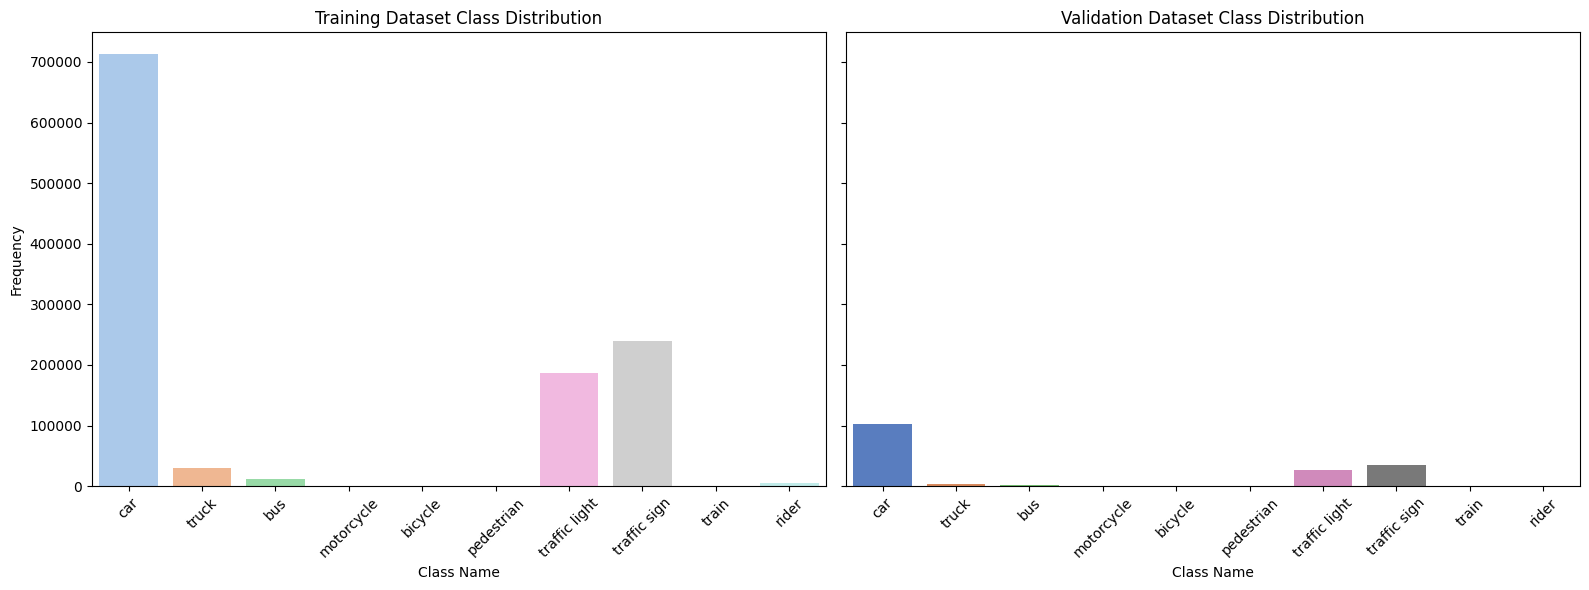

In [ ]:
em.plot_class_distribution(train_labels_df, val_labels_df, class_mapping)

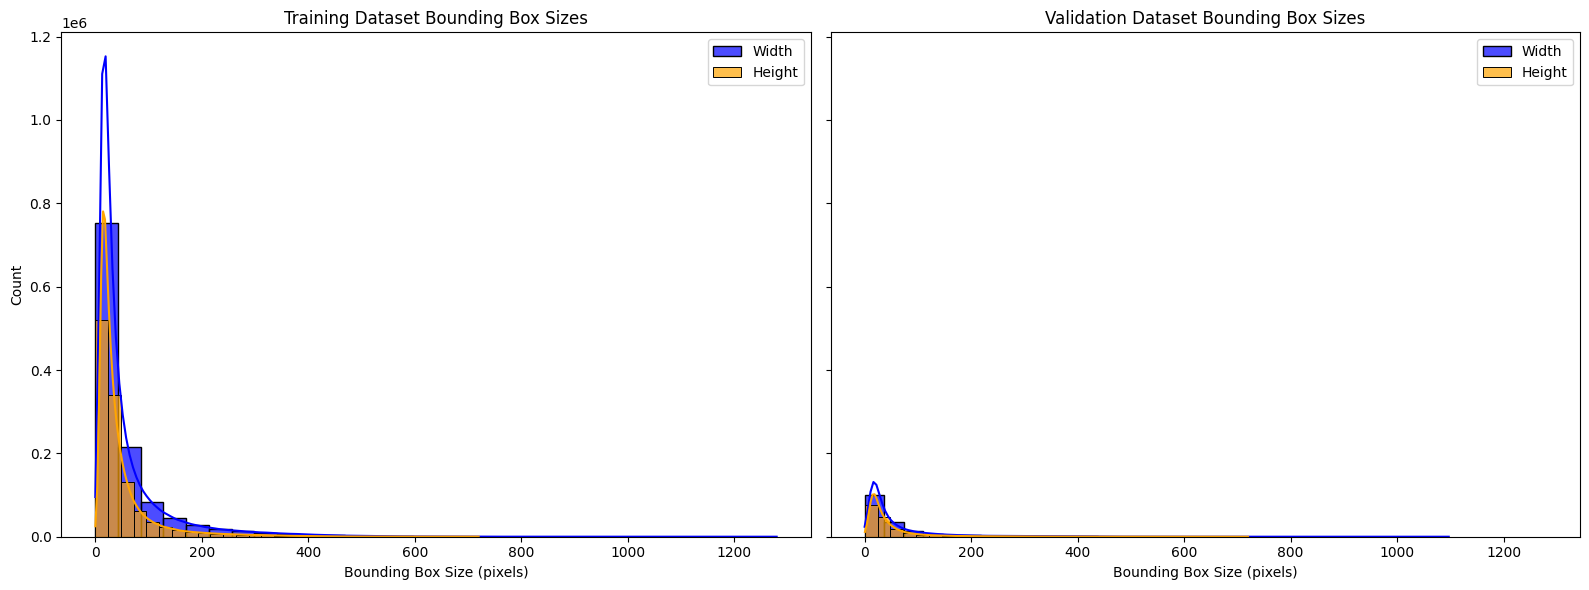

In [ ]:
em.plot_bbox_size_distribution(train_labels_df, val_labels_df)

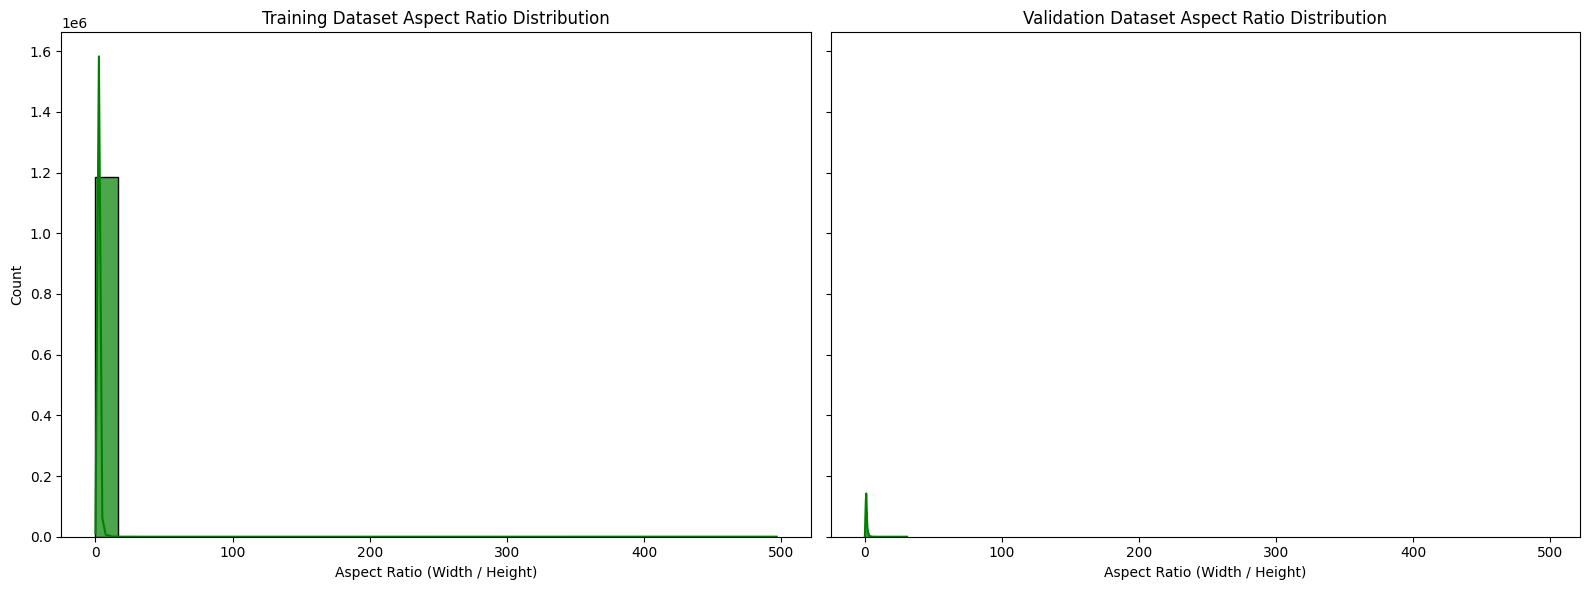

In [ ]:
em.plot_aspect_ratio_distribution(train_labels_df, val_labels_df)

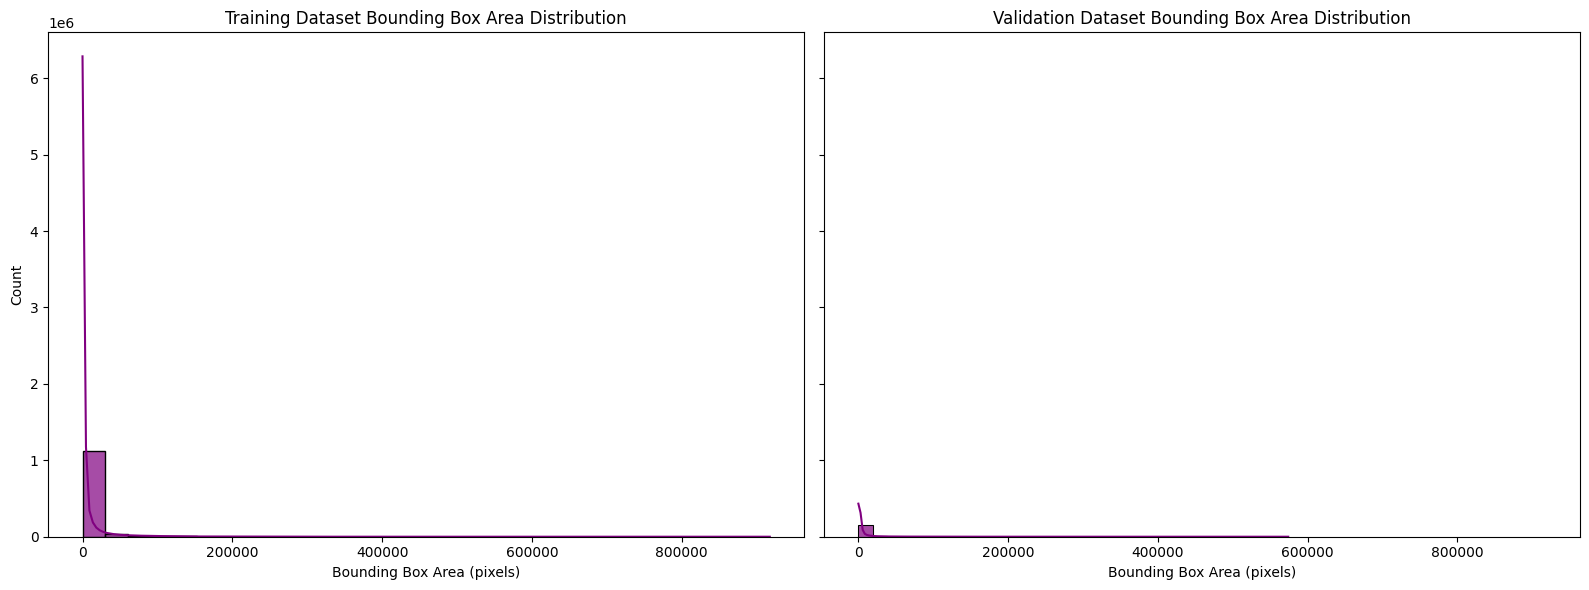

In [ ]:
em.plot_bbox_area_distribution(train_labels_df, val_labels_df)

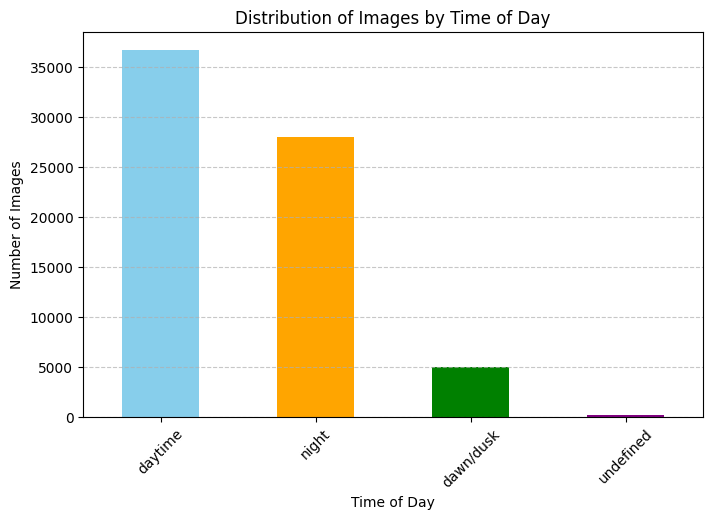

In [ ]:
em.analyze_time_of_day(annotations_train_path)

### YOLO V8

100%|██████████| 6.25M/6.25M [00:00<00:00, 109MB/s]



image 1/1 c:\Users\Aaron\Documents\GitHub\AI2-FP\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 12 cars, 1 truck, 127.0ms
Speed: 11.0ms preprocess, 127.0ms inference, 18.8ms postprocess per image at shape (1, 3, 384, 640)


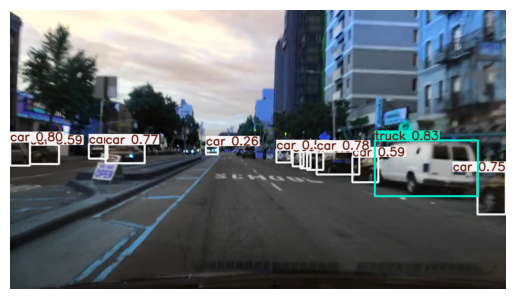

In [20]:

# Load a pre-trained YOLOv8 model (choose from "yolov8n.pt", "yolov8s.pt", "yolov8m.pt", "yolov8l.pt", "yolov8x.pt" based on your requirements)
model = YOLO("yolov8n.pt")  # "yolov8n.pt" is the nano model, which is fastest but least accurate

# Run inference on an image (replace with your image path)
results = model("dataset/images/val/b1c66a42-6f7d68ca.jpg")

# Display results
for result in results:
    boxes = result.boxes
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()


### YOLO V5

100%|██████████████████████████████████████████████████████████████████████████████| 17.7M/17.7M [00:00<00:00, 101MB/s]



image 1/1 C:\Users\Aaron\Jupyter\FinalProj\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 13 cars, 1 truck, 90.0ms
Speed: 2.0ms preprocess, 90.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


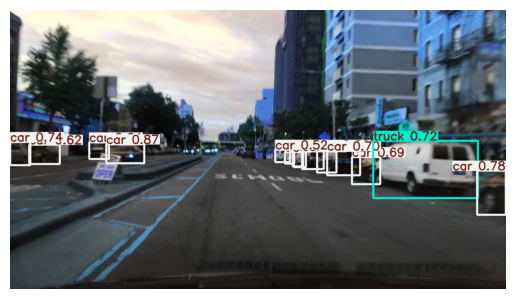

In [ ]:
from ultralytics import YOLO

# Load the pre-trained YOLOv5 model
model = YOLO("yolov5su.pt")  # replace with your desired model size

# Perform inference on a single image
results = model("dataset/images/val/b1c66a42-6f7d68ca.jpg")

# Display results
for result in results:
    boxes = result.boxes
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()



# 3) Model Implementation and Fine-tuning

## Base Model

### Pre-Trained YOLO model without Fine-Tuning

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.)
model = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model.train(
    data="dataset.yaml",  # Path to your custom dataset.yaml file
    epochs=5,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,              # Set batch size (e.g., 8) to control memory usage
    project="runs/train", # Directory where training results will be saved
    name="finetuned_model", # Folder name for saving the model
    exist_ok=True         # Overwrite existing run folder
)


Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=5, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=finetuned_model, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\train... 1995 images, 5 backgrounds, 0 corrupt: 100%|██


train: New cache created: C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\train.cache


val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\val... 1500 images, 0 backgrounds, 0 corrupt: 100%|██████


val: New cache created: C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\val.cache
Plotting labels to runs\train\finetuned_model\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G        1.7       2.59      1.107        414        640: 100%|██████████| 63/63 [09:33<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:49


                   all       1500      25316     0.0354      0.311      0.125     0.0739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.565      1.408      1.072        489        640: 100%|██████████| 63/63 [09:39<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:51


                   all       1500      25316      0.682      0.163        0.2      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.528      1.301      1.057        361        640: 100%|██████████| 63/63 [09:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:39


                   all       1500      25316       0.56       0.23      0.203      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.502      1.231      1.045        355        640: 100%|██████████| 63/63 [08:49<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:35


                   all       1500      25316       0.61      0.236      0.227      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.452      1.157      1.031        475        640: 100%|██████████| 63/63 [08:47<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:34


                   all       1500      25316      0.497      0.267      0.258      0.151

5 epochs completed in 0.916 hours.
Optimizer stripped from runs\train\finetuned_model\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\finetuned_model\weights\best.pt, 6.2MB

Validating runs\train\finetuned_model\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:13


                   all       1500      25316      0.496      0.267      0.258      0.151
                   car       1484      15066      0.526      0.613      0.606       0.36
                 truck        395        634      0.519      0.301       0.32      0.218
                   bus        171        206      0.481      0.315      0.301      0.237
         traffic light        854       4111      0.412      0.251      0.234     0.0787
          traffic sign       1225       5222      0.387      0.346      0.298      0.146
                 train          2          2          1          0          0          0
                 rider         61         75       0.15       0.04     0.0463       0.02
Speed: 1.4ms preprocess, 36.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\train\finetuned_model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000181F7C6DA60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047


image 1/1 c:\Users\Aaron\Documents\GitHub\AI2-FP\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 18 cars, 3 traffic signs, 187.0ms
Speed: 8.4ms preprocess, 187.0ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)


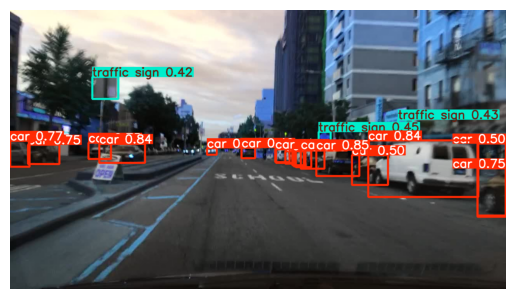

In [9]:
#Test prediction
# Load the model
fine_tuned_model = YOLO("runs/train/finetuned_model/weights/best.pt")

# Run inference on a test image
results = fine_tuned_model("dataset/images/val/b1c66a42-6f7d68ca.jpg")

for result in results:
    result.show()
# Display results
for result in results:
    boxes = result.boxes
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()



## Experimental Models

### Pre-trained YOLO Model with Lower Batch SIZE

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.)
model2 = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model2.train(
    data="dataset.yaml",  # Path to your custom dataset.yaml file
    epochs=5,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=16,              # Set batch size (e.g., 8) to control memory usage
    project="runs/train", # Directory where training results will be saved
    name="finetuned_model2", # Folder name for saving the model
    exist_ok=True         # Overwrite existing run folder
)


Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=finetuned_model2, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\train.cache... 1995 images, 5 backgrounds, 0 corrupt: 1
val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\val.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|


Plotting labels to runs\train\finetuned_model2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.689      2.323      1.107        491        640: 100%|██████████| 125/125 [08:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:31


                   all       1500      25316      0.579      0.175      0.165     0.0926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G       1.56      1.399      1.067        445        640: 100%|██████████| 125/125 [08:07<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:29


                   all       1500      25316      0.575      0.213      0.191      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.543       1.31      1.058        378        640: 100%|██████████| 125/125 [08:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:24


                   all       1500      25316       0.59      0.216      0.212      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.508      1.228      1.046        324        640: 100%|██████████| 125/125 [08:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:24


                   all       1500      25316      0.625      0.242      0.248      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.457      1.156      1.029        622        640: 100%|██████████| 125/125 [08:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:24


                   all       1500      25316      0.461      0.259       0.25      0.144

5 epochs completed in 0.809 hours.
Optimizer stripped from runs\train\finetuned_model2\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\finetuned_model2\weights\best.pt, 6.2MB

Validating runs\train\finetuned_model2\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:08


                   all       1500      25316      0.461      0.258      0.251      0.144
                   car       1484      15066      0.593      0.588      0.616      0.364
                 truck        395        634      0.456      0.273      0.251      0.158
                   bus        171        206      0.254      0.393      0.306      0.243
         traffic light        854       4111      0.469       0.23      0.237     0.0773
          traffic sign       1225       5222      0.451      0.323      0.302      0.146
                 train          2          2          1          0          0          0
                 rider         61         75          0          0     0.0422     0.0191
Speed: 0.9ms preprocess, 34.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\train\finetuned_model2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000181F951A330>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047


image 1/1 C:\Users\Aaron\Jupyter\FinalProj\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 17 cars, 3 traffic signs, 38.0ms
Speed: 2.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


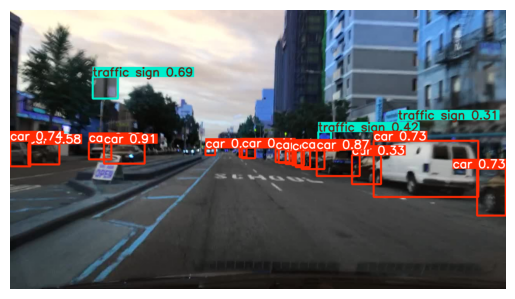

In [ ]:
# Load the fine-tuned model
fine_tuned_model2 = YOLO("runs/train/finetuned_model2/weights/best.pt")

# Run inference on a test image
results = fine_tuned_model2("dataset/images/val/b1c66a42-6f7d68ca.jpg")

for result in results:
    result.show()
# Display results
for result in results:
    boxes = result.boxes
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()



### Increasing Epoch Size from 5 to 10

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.) this time we're using the learned weights from the first model
model3 = YOLO("runs/train/finetuned_model/weights/best.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model3.train(
    data="dataset.yaml",  # Path to your custom dataset.yaml file
    epochs=10,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,              # Set batch size (e.g., 8) to control memory usage
    project="runs/train", # Directory where training results will be saved
    name="finetuned_model3", # Folder name for saving the model
    exist_ok=True         # Overwrite existing run folder
)


Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=runs/train/finetuned_model/weights/best.pt, data=dataset.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=finetuned_model3, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\train.cache... 1995 images, 5 backgrounds, 0 corrupt: 1
val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\val.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|


Plotting labels to runs\train\finetuned_model3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.486      1.254      1.034        250        640: 100%|██████████| 63/63 [08:47<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:51


                   all       1500      25316      0.461      0.262      0.241      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.502      1.222      1.039        287        640: 100%|██████████| 63/63 [08:37<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:37


                   all       1500      25316      0.522      0.245      0.242      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.514      1.206      1.045        261        640: 100%|██████████| 63/63 [08:29<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:35


                   all       1500      25316       0.29      0.239      0.206      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.521      1.178      1.048        263        640: 100%|██████████| 63/63 [08:30<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:36


                   all       1500      25316      0.358      0.263      0.247      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.501      1.127       1.04        309        640: 100%|██████████| 63/63 [08:30<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:39


                   all       1500      25316      0.414      0.257       0.25      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.469      1.084      1.028        277        640: 100%|██████████| 63/63 [08:32<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:37


                   all       1500      25316      0.362      0.288      0.266      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.451      1.044       1.02        287        640: 100%|██████████| 63/63 [08:27<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:36


                   all       1500      25316      0.398      0.269      0.267      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.433      1.019      1.011        261        640: 100%|██████████| 63/63 [08:26<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:35


                   all       1500      25316      0.394      0.284      0.278      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.407     0.9857      1.002        268        640: 100%|██████████| 63/63 [08:23<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:35


                   all       1500      25316      0.434      0.304      0.292      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.397     0.9596     0.9974        238        640: 100%|██████████| 63/63 [08:25<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:35


                   all       1500      25316      0.419      0.299      0.302      0.174

10 epochs completed in 1.711 hours.
Optimizer stripped from runs\train\finetuned_model3\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\finetuned_model3\weights\best.pt, 6.2MB

Validating runs\train\finetuned_model3\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:13


                   all       1500      25316      0.433      0.294      0.302      0.174
                   car       1484      15066      0.609      0.615      0.641      0.381
                 truck        395        634      0.511      0.329      0.351      0.241
                   bus        171        206      0.361      0.374      0.332      0.263
         traffic light        854       4111      0.506      0.296      0.303        0.1
          traffic sign       1225       5222      0.576      0.322      0.349      0.172
                 train          2          2          0          0          0          0
                 rider         61         75      0.464       0.12      0.138     0.0586
Speed: 1.4ms preprocess, 37.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\train\finetuned_model3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001820BAD6060>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047


image 1/1 C:\Users\Aaron\Jupyter\FinalProj\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 22 cars, 3 traffic signs, 37.0ms
Speed: 1.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


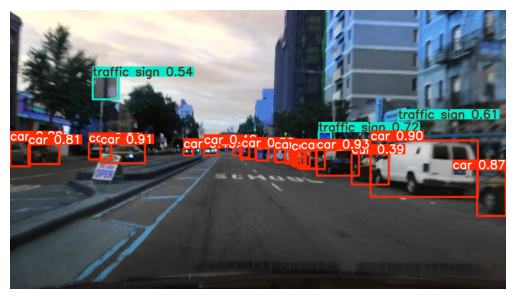

In [ ]:
# Load the fine-tuned model
fine_tuned_model3 = YOLO("runs/train/finetuned_model3/weights/best.pt")

# Run inference on a test image
results = fine_tuned_model3("dataset/images/val/b1c66a42-6f7d68ca.jpg")

for result in results:
    result.show()
# Display results
for result in results:
    boxes = result.boxes
    masks = result.masks
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()



### Using 8s model instead of 8n

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.) this time we're using the learned weights from the first model
model4 = YOLO("yolov8s.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model4.train(
    data="dataset.yaml",  # Path to your custom dataset.yaml file
    epochs=10,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,              # Set batch size (e.g., 8) to control memory usage
    project="runs/train", # Directory where training results will be saved
    name="finetuned_model4", # Folder name for saving the model
    exist_ok=True         # Overwrite existing run folder
)


100%|██████████████████████████████████████████████████████████████████████████████| 21.5M/21.5M [00:00<00:00, 116MB/s]


New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=dataset.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=finetuned_model4, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\train.cache... 1995 images, 5 backgrounds, 0 corrupt: 1
val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\val.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|


Plotting labels to runs\train\finetuned_model4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model4
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G       1.61      2.465      1.114        254        640: 100%|██████████| 63/63 [20:22<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:24


                   all       1500      25316      0.629      0.225      0.229      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.496       1.17      1.057        281        640: 100%|██████████| 63/63 [20:40<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13


                   all       1500      25316      0.463      0.282      0.247       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.466      1.062      1.042        255        640: 100%|██████████| 63/63 [21:33<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:05


                   all       1500      25316       0.32      0.268      0.237      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.463      1.032      1.049        258        640: 100%|██████████| 63/63 [20:22<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:06


                   all       1500      25316      0.389      0.289      0.282      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.443     0.9762      1.034        306        640: 100%|██████████| 63/63 [19:12<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.389      0.307       0.29      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G        1.4     0.9317      1.018        269        640: 100%|██████████| 63/63 [19:10<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07


                   all       1500      25316       0.42      0.316      0.314      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.381     0.8927      1.011        289        640: 100%|██████████| 63/63 [20:30<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:05


                   all       1500      25316      0.481      0.329      0.337      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.347     0.8506     0.9959        263        640: 100%|██████████| 63/63 [21:06<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:10


                   all       1500      25316       0.46       0.33      0.346      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.322     0.8175     0.9862        261        640: 100%|██████████| 63/63 [20:22<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:05


                   all       1500      25316      0.501      0.339      0.357      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.302     0.7887     0.9808        245        640: 100%|██████████| 63/63 [20:39<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:09


                   all       1500      25316      0.491      0.349      0.371      0.216

10 epochs completed in 3.938 hours.
Optimizer stripped from runs\train\finetuned_model4\weights\last.pt, 22.5MB
Optimizer stripped from runs\train\finetuned_model4\weights\best.pt, 22.5MB

Validating runs\train\finetuned_model4\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:33


                   all       1500      25316       0.49      0.349      0.371      0.216
                   car       1484      15066      0.676      0.652      0.691       0.42
                 truck        395        634      0.615      0.371      0.446      0.305
                   bus        171        206      0.537      0.442      0.417      0.324
         traffic light        854       4111      0.596      0.371      0.395      0.138
          traffic sign       1225       5222      0.651      0.392      0.449       0.23
                 train          2          2          0          0          0          0
                 rider         61         75      0.355      0.213        0.2      0.096
Speed: 1.6ms preprocess, 91.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\train\finetuned_model4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000024EEA73C950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047


image 1/1 C:\Users\Aaron\Jupyter\FinalProj\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 18 cars, 2 traffic lights, 2 traffic signs, 169.7ms
Speed: 8.0ms preprocess, 169.7ms inference, 20.0ms postprocess per image at shape (1, 3, 384, 640)


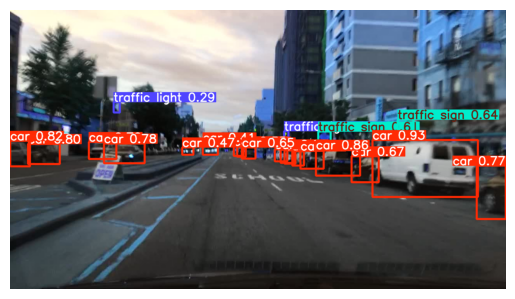

In [ ]:
# Load the fine-tuned model
fine_tuned_model4 = YOLO("runs/train/finetuned_model4/weights/best.pt")

# Run inference on a test image
results = fine_tuned_model4("dataset/images/val/b1c66a42-6f7d68ca.jpg")

for result in results:
    result.show()
# Display results
for result in results:
    boxes = result.boxes
    masks = result.masks
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()



### Training Model with FREEZED backbone layers (feature extraction layers)

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model5 = YOLO("yolov8s.pt")


# Train the model with the updated syntax
model5.train(
    data="dataset.yaml",  # Path to your custom dataset.yaml file
    epochs=100,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,              # Set batch size (e.g., 8) to control memory usage
    project="runs/train", # Directory where training results will be saved
    name="finetuned_model5", # Folder name for saving the model
    exist_ok=True,         # Overwrite existing run folder
    workers=6,             # Number of data loading workers
    save_period=2,         # Save model every 2 epochs
    verbose=False,          # Suppress verbose output
    freeze =10
)


New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=dataset.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=2, cache=False, device=None, workers=6, project=runs/train, name=finetuned_model5, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\train.cache... 1995 images, 5 backgrounds, 0 corrupt: 1
val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset\labels\val.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|


Plotting labels to runs\train\finetuned_model5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.588      2.164      1.111        534        640: 100%|██████████| 63/63 [11:59<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:06


                   all       1500      25316      0.597      0.247      0.248      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.462      1.145       1.05        469        640: 100%|██████████| 63/63 [11:56<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:02


                   all       1500      25316      0.428      0.274      0.276      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.461      1.081      1.047        410        640: 100%|██████████| 63/63 [11:59<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:01


                   all       1500      25316      0.435      0.303       0.29       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.459      1.048      1.049        352        640: 100%|██████████| 63/63 [12:02<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:02


                   all       1500      25316       0.46      0.295      0.304      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.431      1.003      1.034        603        640: 100%|██████████| 63/63 [11:50<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316       0.42      0.294      0.298      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.406     0.9771      1.026        477        640: 100%|██████████| 63/63 [11:52<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.459      0.297      0.299      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.404     0.9545      1.027        536        640: 100%|██████████| 63/63 [11:52<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.427      0.317      0.308       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.398     0.9549      1.021        398        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.463      0.327      0.334       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.391     0.9264      1.016        569        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:00


                   all       1500      25316      0.456      0.313      0.325      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.382     0.9128      1.012        377        640: 100%|██████████| 63/63 [11:59<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:02


                   all       1500      25316      0.591       0.34      0.325      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.373     0.9008      1.007        377        640: 100%|██████████| 63/63 [11:59<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:02


                   all       1500      25316      0.559      0.331      0.325       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.371     0.8927      1.012        399        640: 100%|██████████| 63/63 [11:50<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316       0.61       0.34      0.336      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.357     0.8835      1.003        667        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.585      0.326      0.341      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.339     0.8681     0.9974        382        640: 100%|██████████| 63/63 [11:47<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.609      0.329      0.341      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.331     0.8579     0.9976        345        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.553      0.328      0.335      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.335     0.8512     0.9983        489        640: 100%|██████████| 63/63 [11:52<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.595      0.335      0.337      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.334     0.8429     0.9906        473        640: 100%|██████████| 63/63 [11:46<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.602      0.334      0.346      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.304      0.825     0.9894        580        640: 100%|██████████| 63/63 [11:50<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.599      0.328      0.337      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.309     0.8244     0.9869        435        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59

                   all       1500      25316      0.611      0.344      0.353      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.315     0.8207     0.9863        526        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:57


                   all       1500      25316      0.607      0.341      0.345      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.308     0.8172     0.9861        402        640: 100%|██████████| 63/63 [11:47<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.627       0.32      0.349      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.303     0.8015     0.9823        486        640: 100%|██████████| 63/63 [11:47<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.601      0.327      0.336      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G        1.3     0.8023      0.981        581        640: 100%|██████████| 63/63 [11:45<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.601      0.339      0.345      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.295     0.7936     0.9796        411        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.646      0.328      0.353      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.281     0.7865     0.9741        471        640: 100%|██████████| 63/63 [11:50<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59

                   all       1500      25316      0.607      0.339      0.351      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.287     0.7911     0.9758        559        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58

                   all       1500      25316       0.57      0.337      0.335       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.292     0.7864     0.9735        419        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.581      0.336      0.342      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.278      0.776     0.9708        288        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.591      0.338      0.336      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.278     0.7741     0.9719        366        640: 100%|██████████| 63/63 [11:46<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.588      0.337      0.335       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.286     0.7793     0.9713        535        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59

                   all       1500      25316      0.615      0.347      0.355      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.267     0.7652      0.971        409        640: 100%|██████████| 63/63 [11:45<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316       0.59       0.35      0.351      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.281     0.7764     0.9705        767        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.622      0.332      0.351      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.262     0.7573     0.9672        378        640: 100%|██████████| 63/63 [11:45<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.612      0.347      0.354      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.253     0.7541     0.9646        415        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58

                   all       1500      25316      0.622      0.349      0.353      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.263     0.7588     0.9669        558        640: 100%|██████████| 63/63 [11:47<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58

                   all       1500      25316      0.627       0.35       0.36      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.251     0.7435      0.962        425        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58

                   all       1500      25316      0.621      0.345      0.358      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.247     0.7436     0.9593        411        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:59


                   all       1500      25316      0.651      0.333      0.351      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.247     0.7375     0.9613        492        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:57

                   all       1500      25316      0.587      0.351      0.356      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G       1.26     0.7484     0.9672        500        640: 100%|██████████| 63/63 [11:47<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.618      0.344      0.353      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.237     0.7289     0.9587        296        640: 100%|██████████| 63/63 [11:48<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58


                   all       1500      25316      0.631      0.346      0.359      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.239     0.7334     0.9586        453        640: 100%|██████████| 63/63 [11:44<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58

                   all       1500      25316      0.623      0.352      0.354      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.235     0.7316      0.953        577        640: 100%|██████████| 63/63 [11:49<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:57

                   all       1500      25316      0.616      0.348      0.348      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.227     0.7244     0.9542        432        640: 100%|██████████| 63/63 [11:56<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:01

                   all       1500      25316      0.633      0.354      0.359        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.229     0.7213     0.9511        382        640: 100%|██████████| 63/63 [12:26<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:24


                   all       1500      25316      0.633      0.345      0.363      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.227     0.7181      0.948        600        640: 100%|██████████| 63/63 [13:31<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:26


                   all       1500      25316      0.651      0.341      0.359      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      1.229     0.7147     0.9523        475        640: 100%|██████████| 63/63 [13:52<00:00, 13.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:34


                   all       1500      25316      0.628      0.349      0.359      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.213     0.7108       0.95        490        640: 100%|██████████| 63/63 [12:57<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:12


                   all       1500      25316      0.648      0.325      0.345      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.227     0.7107     0.9537        526        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07


                   all       1500      25316       0.62      0.338      0.348      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.222     0.7143     0.9505        516        640: 100%|██████████| 63/63 [12:47<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13

                   all       1500      25316      0.622      0.344      0.357      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.219     0.7047     0.9471        710        640: 100%|██████████| 63/63 [12:44<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:12


                   all       1500      25316      0.601      0.341      0.341      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G      1.208     0.7023     0.9433        449        640: 100%|██████████| 63/63 [13:08<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:19


                   all       1500      25316      0.593      0.349      0.354      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.214     0.6995     0.9453        379        640: 100%|██████████| 63/63 [13:33<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:16


                   all       1500      25316      0.621      0.344      0.353      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      1.196     0.6942     0.9434        412        640: 100%|██████████| 63/63 [13:07<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:16


                   all       1500      25316      0.616      0.348      0.354      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.211      0.698     0.9449        646        640: 100%|██████████| 63/63 [13:00<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:18


                   all       1500      25316      0.647      0.333       0.36      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.202     0.6922     0.9455        473        640: 100%|██████████| 63/63 [13:11<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:20


                   all       1500      25316      0.618      0.347      0.357      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.197     0.6901     0.9457        533        640: 100%|██████████| 63/63 [13:01<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:14


                   all       1500      25316      0.621      0.336      0.349      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.205     0.6856      0.945        506        640: 100%|██████████| 63/63 [13:14<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:14


                   all       1500      25316      0.621      0.348      0.361      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G        1.2     0.6868     0.9447        422        640: 100%|██████████| 63/63 [13:23<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:20


                   all       1500      25316      0.637      0.352      0.365      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.205     0.6916     0.9446        530        640: 100%|██████████| 63/63 [12:58<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13


                   all       1500      25316      0.504      0.341      0.363      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.187     0.6803     0.9381        424        640: 100%|██████████| 63/63 [15:14<00:00, 14.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [04:07


                   all       1500      25316      0.663      0.334      0.359      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      1.176      0.677     0.9376        494        640: 100%|██████████| 63/63 [13:13<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:10


                   all       1500      25316      0.645      0.347      0.362      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.186       0.68     0.9378        551        640: 100%|██████████| 63/63 [12:52<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:12


                   all       1500      25316      0.627      0.338      0.362        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.178     0.6727     0.9381        437        640: 100%|██████████| 63/63 [12:49<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:27


                   all       1500      25316      0.634      0.333       0.36      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.194       0.68     0.9408        453        640: 100%|██████████| 63/63 [13:00<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.649      0.345      0.365      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.174     0.6686     0.9348        520        640: 100%|██████████| 63/63 [12:33<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.645      0.346       0.36        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      1.188     0.6719     0.9406        462        640: 100%|██████████| 63/63 [12:32<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.645      0.343      0.363      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      1.173     0.6694     0.9353        489        640: 100%|██████████| 63/63 [12:32<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.663      0.342      0.365      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.174     0.6691     0.9347        501        640: 100%|██████████| 63/63 [12:35<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07


                   all       1500      25316      0.645      0.351      0.367      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.173     0.6595     0.9343        418        640: 100%|██████████| 63/63 [12:31<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.628      0.348      0.368      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      1.172     0.6621     0.9309        426        640: 100%|██████████| 63/63 [12:33<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.614      0.352      0.359      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      1.168     0.6596     0.9291        592        640: 100%|██████████| 63/63 [12:30<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.609      0.349      0.357      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      1.165     0.6583     0.9304        500        640: 100%|██████████| 63/63 [12:33<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316       0.67      0.335      0.367      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      1.161     0.6568     0.9323        438        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07

                   all       1500      25316       0.63      0.357      0.367      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.159     0.6546      0.932        521        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.635      0.356      0.369      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.166     0.6548     0.9316        381        640: 100%|██████████| 63/63 [12:33<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:12

                   all       1500      25316      0.635      0.341      0.359      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G       1.17      0.655      0.936        432        640: 100%|██████████| 63/63 [12:33<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:06

                   all       1500      25316      0.623       0.36      0.366      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      1.161     0.6482     0.9323        446        640: 100%|██████████| 63/63 [12:30<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.638      0.355      0.368      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.158     0.6511     0.9299        519        640: 100%|██████████| 63/63 [12:30<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07

                   all       1500      25316      0.637      0.353      0.367      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      1.156     0.6472     0.9298        496        640: 100%|██████████| 63/63 [12:30<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.617      0.349      0.363      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      1.156     0.6463      0.928        369        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.482       0.36      0.364      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.147     0.6459     0.9252        596        640: 100%|██████████| 63/63 [12:31<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07

                   all       1500      25316      0.616      0.355      0.364      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G       1.15     0.6404     0.9232        485        640: 100%|██████████| 63/63 [12:32<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07

                   all       1500      25316      0.633       0.35      0.367      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.146     0.6404     0.9267        543        640: 100%|██████████| 63/63 [12:32<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08

                   all       1500      25316      0.505       0.35      0.366      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      1.143     0.6385     0.9276        464        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.632      0.353       0.37      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.147     0.6371     0.9289        429        640: 100%|██████████| 63/63 [12:29<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07


                   all       1500      25316      0.633      0.358      0.369      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.136     0.6325      0.921        586        640: 100%|██████████| 63/63 [12:40<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:11

                   all       1500      25316      0.644      0.353      0.366        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      1.143      0.632     0.9242        386        640: 100%|██████████| 63/63 [13:09<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:25


                   all       1500      25316      0.653      0.351      0.366      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      1.124     0.6247     0.9186        461        640: 100%|██████████| 63/63 [13:17<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316      0.635      0.348      0.363        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.139     0.6254      0.923        534        640: 100%|██████████| 63/63 [12:40<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13


                   all       1500      25316      0.658      0.348      0.364      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      1.135     0.6288     0.9235        535        640: 100%|██████████| 63/63 [13:23<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:23


                   all       1500      25316      0.656      0.344      0.364      0.201
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G      1.272     0.7428     0.9595        271        640: 100%|██████████| 63/63 [12:47<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:11


                   all       1500      25316       0.61      0.334      0.339      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      1.258     0.7245      0.955        223        640: 100%|██████████| 63/63 [13:12<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:09


                   all       1500      25316      0.465      0.329      0.332      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      1.241     0.7048     0.9491        255        640: 100%|██████████| 63/63 [12:07<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:08


                   all       1500      25316       0.62      0.328      0.337      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      1.246     0.7036     0.9526        282        640: 100%|██████████| 63/63 [12:06<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13


                   all       1500      25316      0.615      0.324      0.339      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G      1.239     0.7022     0.9446        251        640: 100%|██████████| 63/63 [12:10<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:09


                   all       1500      25316      0.616      0.325       0.34      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G      1.236     0.6918     0.9468        229        640: 100%|██████████| 63/63 [12:04<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:10


                   all       1500      25316      0.621      0.327      0.341      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      1.231     0.6948     0.9431        176        640: 100%|██████████| 63/63 [12:06<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:07


                   all       1500      25316      0.601      0.326       0.34      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G      1.233     0.6938     0.9442        278        640: 100%|██████████| 63/63 [12:28<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:13


                   all       1500      25316      0.602      0.332      0.341      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      1.228     0.6887     0.9414        317        640: 100%|██████████| 63/63 [14:46<00:00, 14.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [04:56


                   all       1500      25316      0.597      0.338      0.345      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G       1.23       0.69     0.9469        242        640: 100%|██████████| 63/63 [18:56<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [05:00


                   all       1500      25316      0.599      0.339      0.345      0.192

100 epochs completed in 26.089 hours.
Optimizer stripped from runs\train\finetuned_model5\weights\last.pt, 22.5MB
Optimizer stripped from runs\train\finetuned_model5\weights\best.pt, 22.5MB

Validating runs\train\finetuned_model5\weights\best.pt...
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [04:04


                   all       1500      25316      0.632      0.353      0.369      0.205
Speed: 2.3ms preprocess, 143.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\train\finetuned_model5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000015719F721B0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

### Training Model with 100k images

In [10]:
## Copy result ni lance

### Balance vs Unbalanced Dataset

In [ ]:
# 1500 random images (unbalanced not handpicked)

from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.) this time we're using the learned weights from the first model
model6 = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model6.train(
    data="dataset2.yaml",  # Path to your custom dataset.yaml file
    epochs=10,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,             # Set batch size to control memory usage
    project="runs/train", # Directory where training results will be saved
    name="finetuned_model6", # Folder name for saving the model
    exist_ok=True,        # Overwrite existing run folder
    workers=6,            # Number of data loading workers
    save_period=2,        # Save model every 2 epochs
    verbose=False,        # Suppress verbose output
    freeze=10,            # Freeze the backbone
    lr0=0.01,             # Initial learning rate
    lrf=0.01,              # Final learning rate (used for cosine decay scheduler)
    optimizer="Adam",
    cos_lr = True
)


New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset2.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=2, cache=False, device=None, workers=6, project=runs/train, name=finetuned_model6, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\train... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:01<00:00, 834.45it/s]


train: New cache created: C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\train.cache


val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\val... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 902.52it/s]


val: New cache created: C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\val.cache
Plotting labels to runs\train\finetuned_model6\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model6
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G       1.94      2.435       1.26        497        640:  78%|███████▊  | 25/32 [02:26<00:40,  5.79s/it]

In [ ]:
# data augmented

from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.) this time we're using the learned weights from the first model
model9 = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model9.train(
    data="dataset4.yaml",  # Path to your custom dataset.yaml file
    epochs=10,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,             # Set batch size to control memory usage
    project="runs/train", # Directory where training results will be saved
    name="finetuned_model9", # Folder name for saving the model
    exist_ok=True,        # Overwrite existing run folder
    workers=6,            # Number of data loading workers
    save_period=2,        # Save model every 2 epochs
    verbose=False,        # Suppress verbose output
    freeze=10,            # Freeze the backbone
    lr0=0.01,             # Initial learning rate
    lrf=0.01,              # Final learning rate (used for cosine decay scheduler)
    optimizer="Adam",
    cos_lr = True,        # Overwrite existing run folder
    augment=True,
)


New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset4.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=2, cache=False, device=None, workers=6, project=runs/train, name=finetuned_model9, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

train: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\train.cache... 0 images, 1000 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

WARNING  No labels found in C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\train.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



val: Scanning C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\val.cache... 0 images, 500 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

WARNING  No labels found in C:\Users\Aaron\Jupyter\FinalProj\dataset_1500\labels\val.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
Plotting labels to runs\train\finetuned_model9\labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model9
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G          0      257.4          0          0        640:   3%|▎         | 1/32 [00:05<02:44,  5.29s/it]


KeyboardInterrupt: 

In [ ]:
# 1500 random images (unbalanced not handpicked)

from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., yolov8n.pt, yolov8s.pt, etc.) this time we're using the learned weights from the first model
model8 = YOLO("yolov8n.pt")  # You can choose different versions depending on the speed and accuracy you need

# Train the model with the updated syntax
model8.train(
    data="dataset3.yaml",  # Path to your custom dataset.yaml file
    epochs=10,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,             # Set batch size to control memory usage
    project="runs/train", # Directory where training results will be saved
    name="finetuned_model8", # Folder name for saving the model
    exist_ok=True,        # Overwrite existing run folder
    workers=6,            # Number of data loading workers
    save_period=2,        # Save model every 2 epochs
    verbose=False,        # Suppress verbose output
    freeze=10,            # Freeze the backbone
    lr0=0.01,             # Initial learning rate
    lrf=0.01,              # Final learning rate (used for cosine decay scheduler)
    optimizer="Adam",
    cos_lr = True        # Overwrite existing run folder
)


### Data Augmentation

### Hyperparameter Combinations

### Dropouts and Regularization

# 4) Results and Analysis of Models

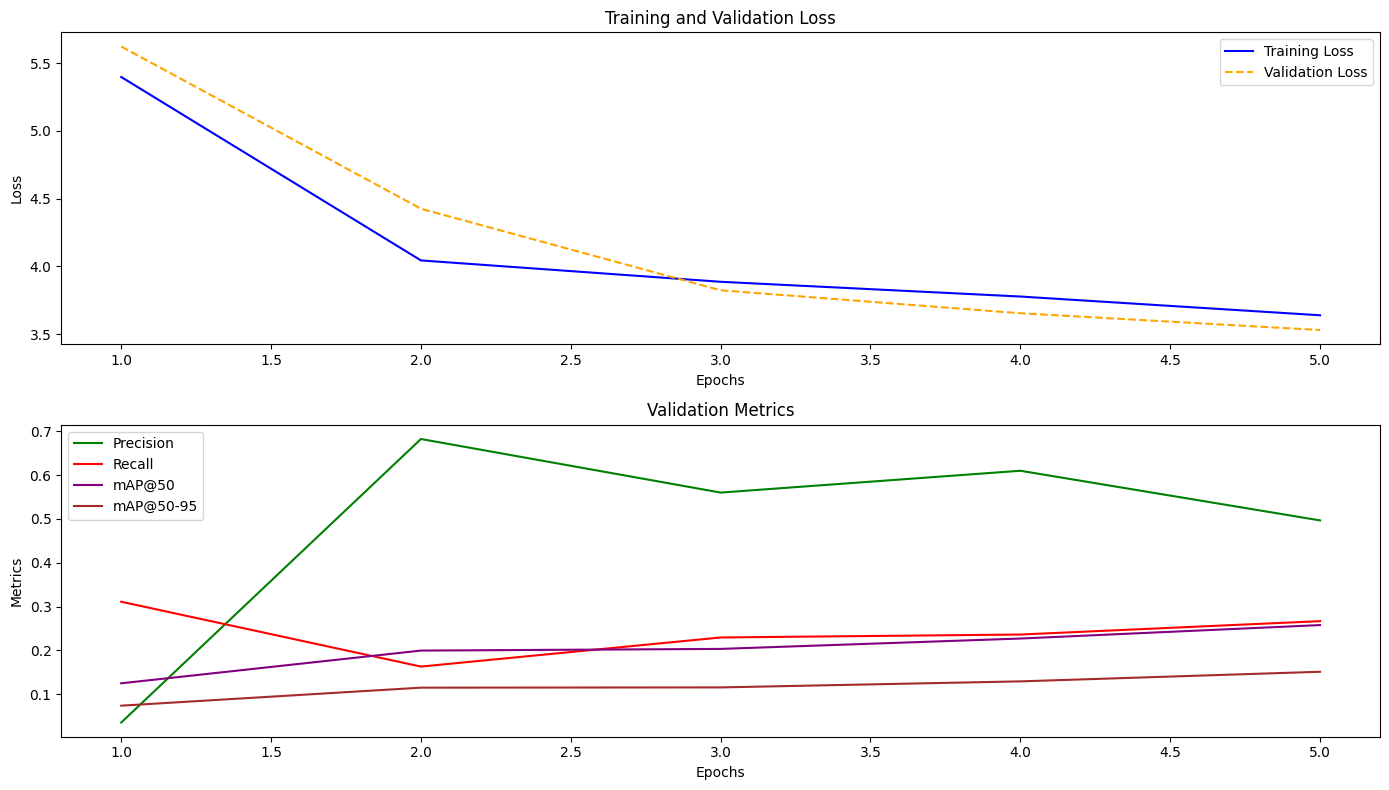

In [5]:
mt.plot_yolo_metrics("runs/train/finetuned_model/results.csv")

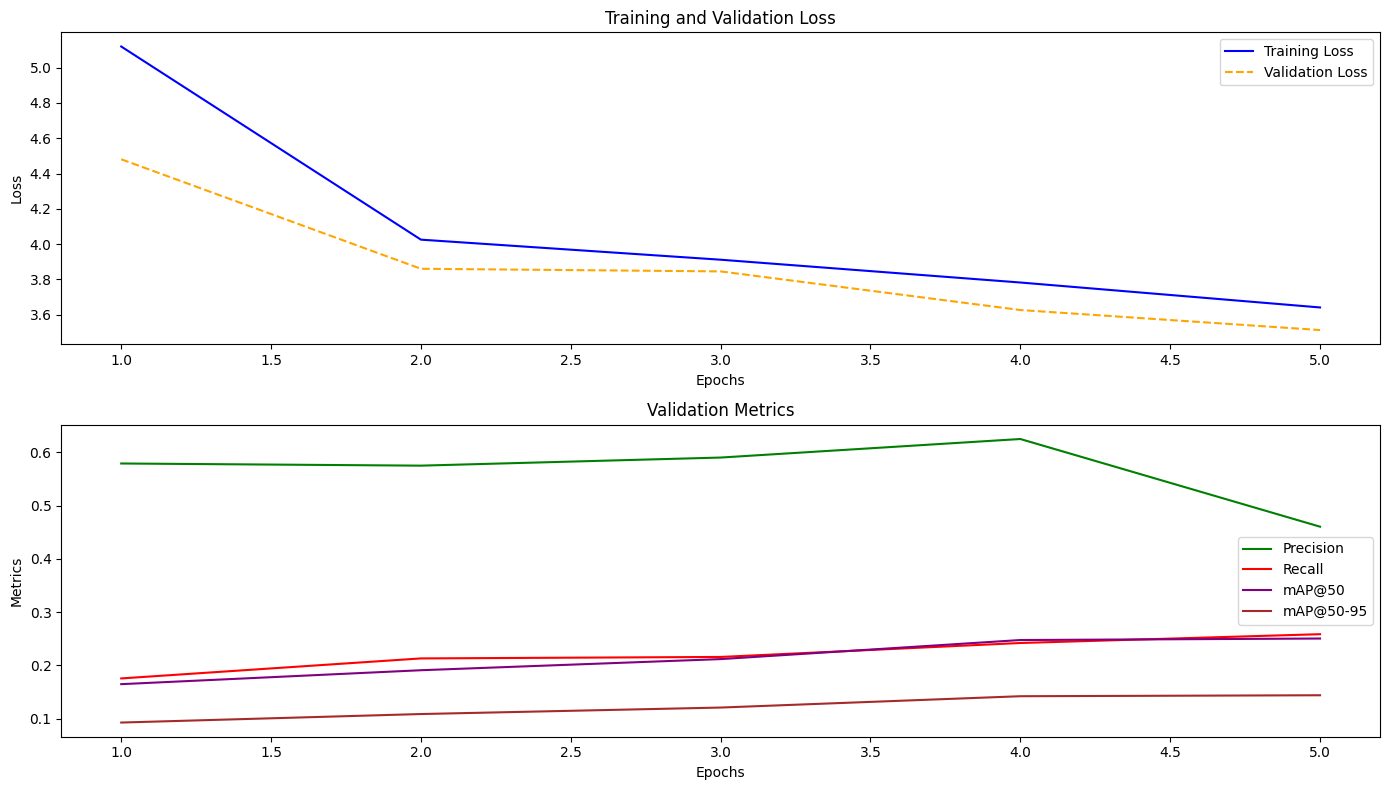

In [6]:
mt.plot_yolo_metrics("runs/train/finetuned_model2/results.csv")

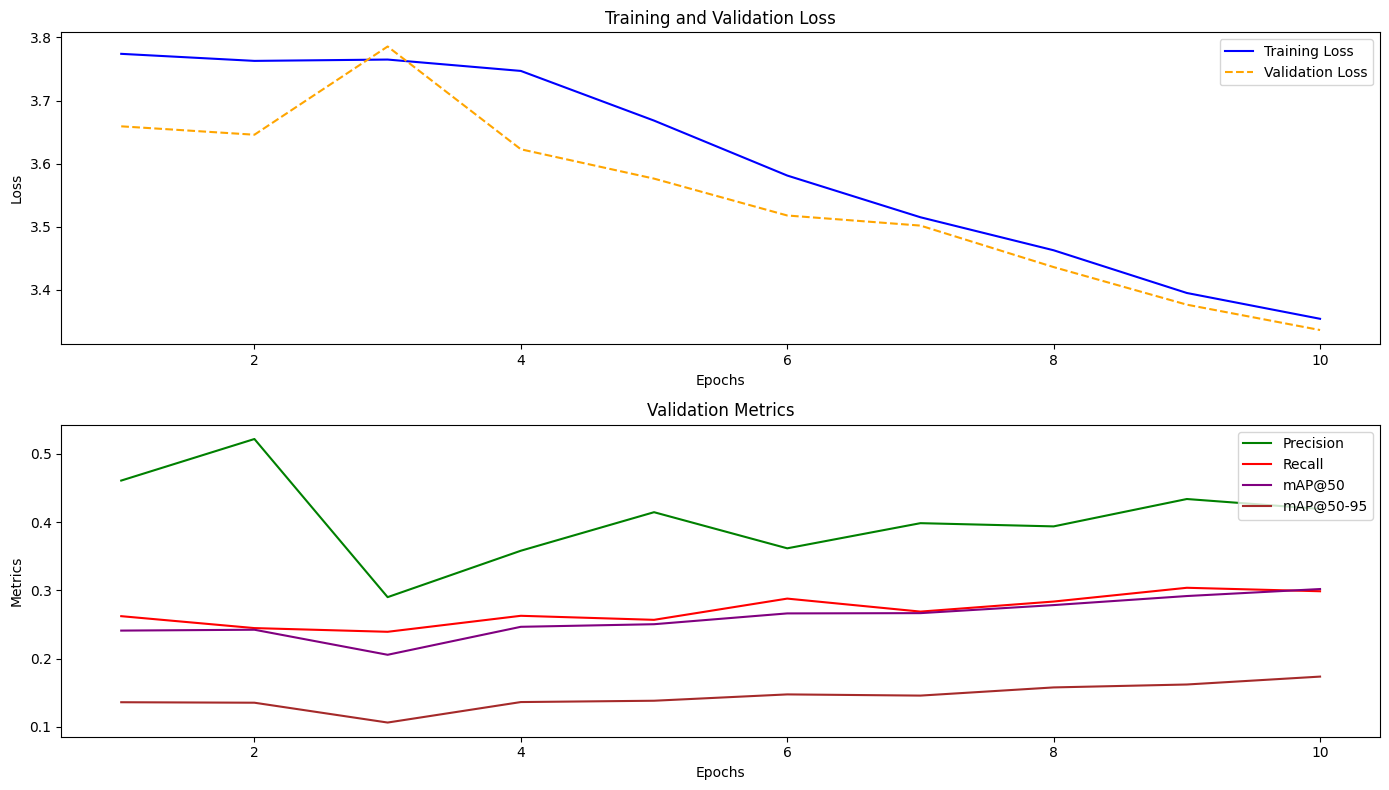

In [7]:
mt.plot_yolo_metrics("runs/train/finetuned_model3/results.csv")

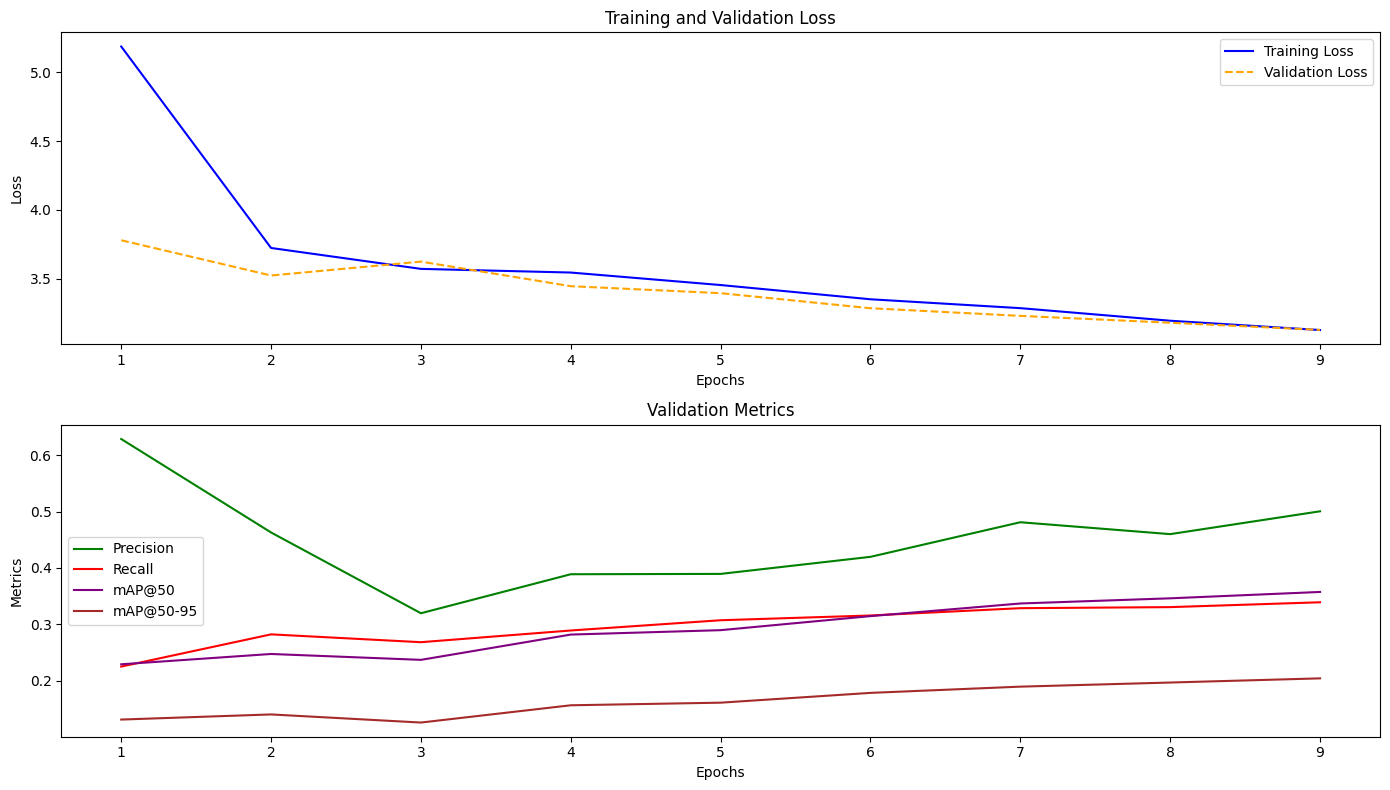

In [8]:
mt.plot_yolo_metrics("runs/train/finetuned_model4/results.csv")

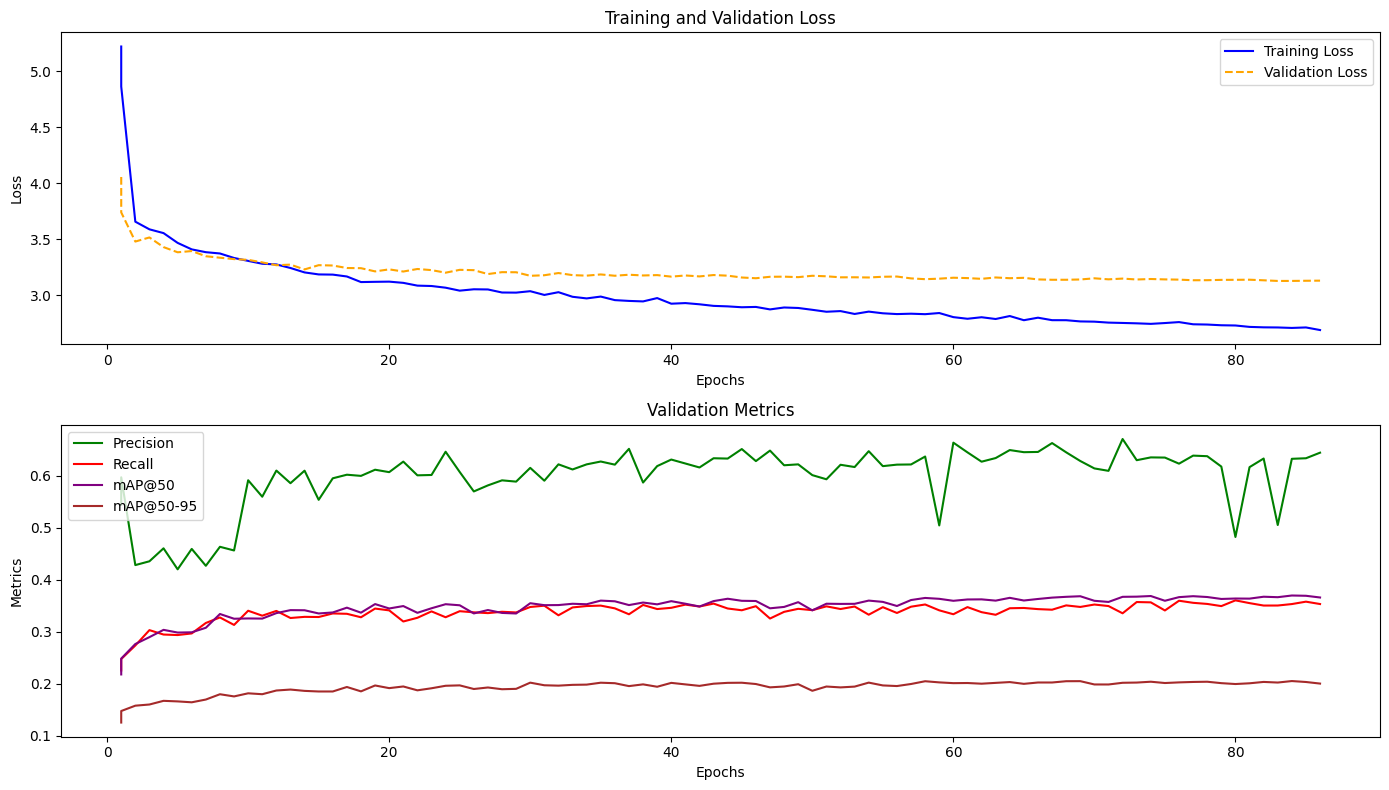

In [ ]:
mt.plot_yolo_metrics("runs/train/finetuned_model5/results.csv")

In [18]:
g_model = YOLO("runs/train/finetuned_model5/weights/best.pt")

#g_model.val()
# Run inference on a test image
results = g_model("dataset/images/val/b1c66a42-6f7d68ca.jpg")



image 1/1 c:\Users\Aaron\Documents\GitHub\AI2-FP\dataset\images\val\b1c66a42-6f7d68ca.jpg: 384x640 17 cars, 2 traffic lights, 4 traffic signs, 177.2ms
Speed: 3.1ms preprocess, 177.2ms inference, 12.2ms postprocess per image at shape (1, 3, 384, 640)


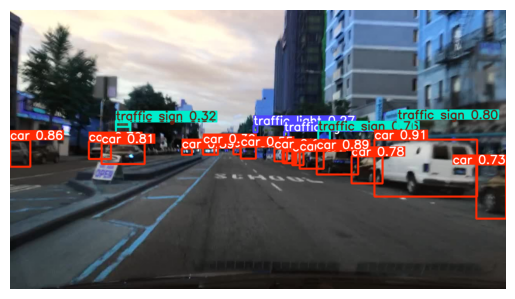

In [19]:
for result in results:
    boxes = result.boxes
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()


In [58]:


from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model9 = YOLO("yolov8n.pt")

# Train the model with a learning rate scheduler
model9.train(
    data="dataset.yaml",  # Path to your custom dataset.yaml file
    epochs=10,            # Number of training epochs
    imgsz=640,            # Image size (YOLO generally works well with 640 or 1280)
    batch=32,             # Set batch size to control memory usage
    project="runs/train", # Directory where training results will be saved
    name="finetuned_model7", # Folder name for saving the model
    exist_ok=True,        # Overwrite existing run folder
    workers=6,            # Number of data loading workers
    save_period=2,        # Save model every 2 epochs
    verbose=False,        # Suppress verbose output
    freeze=10,            # Freeze the backbone
    lr0=0.01,             # Initial learning rate
    lrf=0.01,              # Final learning rate (used for cosine decay scheduler)
    optimizer="Adam",
    cos_lr = True
)


New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=2, cache=False, device=None, workers=6, project=runs/train, name=finetuned_model7, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

train: Scanning C:\Users\Aaron\Documents\GitHub\AI2-FP\dataset\labels\train.cache... 1995 images, 5 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]
val: Scanning C:\Users\Aaron\Documents\GitHub\AI2-FP\dataset\labels\val.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1500/1500 [00:00<?, ?it/s]

Plotting labels to runs\train\finetuned_model7\labels.jpg... 


optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\finetuned_model7
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.921      2.036      1.246        250        640: 100%|██████████| 63/63 [09:14<00:00,  8.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:55<00:00,  7.33s/it]


                   all       1500      25316      0.296      0.161     0.0706     0.0314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.921      1.547      1.265        287        640: 100%|██████████| 63/63 [09:17<00:00,  8.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:58<00:00,  7.43s/it]


                   all       1500      25316      0.323      0.158      0.103     0.0497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.848      1.425      1.224        261        640: 100%|██████████| 63/63 [09:00<00:00,  8.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:43<00:00,  6.83s/it]


                   all       1500      25316      0.487      0.154       0.12     0.0586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.802       1.37      1.211        263        640: 100%|██████████| 63/63 [06:39<00:00,  6.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:40<00:00,  4.20s/it]


                   all       1500      25316      0.374      0.161      0.141     0.0702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.748      1.293      1.178        309        640: 100%|██████████| 63/63 [05:54<00:00,  5.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:44<00:00,  4.34s/it]


                   all       1500      25316      0.542      0.205      0.167     0.0855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.704       1.25      1.163        277        640: 100%|██████████| 63/63 [05:58<00:00,  5.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:41<00:00,  4.22s/it]


                   all       1500      25316      0.377      0.195      0.174     0.0898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.665      1.203      1.139        287        640: 100%|██████████| 63/63 [05:50<00:00,  5.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:39<00:00,  4.15s/it]


                   all       1500      25316      0.569      0.217      0.194      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.621      1.158      1.121        588        640:  67%|██████▋   | 42/63 [04:01<02:00,  5.75s/it]


KeyboardInterrupt: 


image 1/1 c:\Users\Aaron\Documents\GitHub\AI2-FP\dataset\images\test\fbbb7d94-e04ac7a3.jpg: 384x640 5 cars, 1 truck, 1 bus, 4 traffic lights, 143.6ms
Speed: 0.0ms preprocess, 143.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


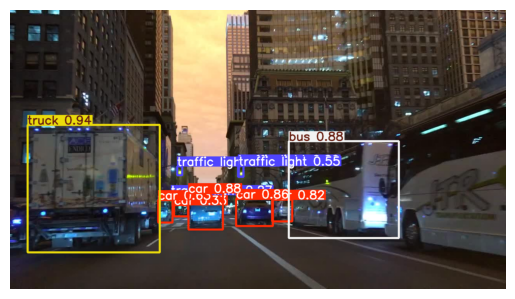

In [ ]:

s_model = YOLO("runs/train/finetuned_model7/weights/best.pt")

# Run inference on a test image
results = s_model("dataset/images/test/fbbb7d94-e04ac7a3.jpg")


for result in results:
    boxes = result.boxes
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()



image 1/1 c:\Users\Aaron\Documents\GitHub\AI2-FP\dataset\images\test\fbbb7d94-e04ac7a3.jpg: 384x640 5 cars, 1 truck, 1 bus, 4 traffic lights, 143.6ms
Speed: 0.0ms preprocess, 143.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


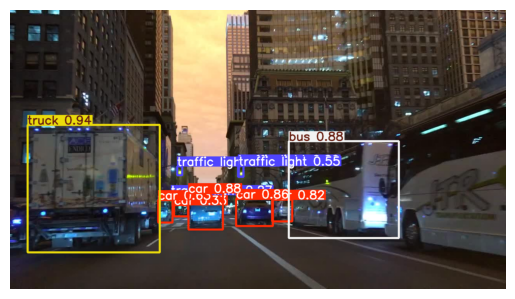

In [42]:

s_model = YOLO("runs/train/finetuned_model5/weights/best.pt")

# Run inference on a test image
results = s_model("dataset/images/test/fbbb7d94-e04ac7a3.jpg")


for result in results:
    boxes = result.boxes
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()
